In [1]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.special import erf
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import mitiq

# Qiskit for pulse 
from qiskit import pulse

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate

# Fake backend
#from qiskit.test.mock import FakeAthens

from scipy import integrate

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

In [3]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='iowa-state-uni-1', project='main')
print(provider)
backend = provider.get_backend('ibmq_bogota')
properties = backend.properties()

<AccountProvider for IBMQ(hub='ibm-q-research-2', group='iowa-state-uni-1', project='main')>


In [5]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
# Used in pulse gate
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [6]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [7]:
def flip(n,i,L):  # flip the spin on i site for state n like flip the 0 site of '10001'->'00001'
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))

#The function to covert the binary number to the decimal number.
#@jit
def binaryToDecimal(binary): 
      
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

#@jit 
def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

#Pauli matrix y
#@jit
def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

#Pauli matrix z
#@jit
def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[3:][i])-1
    return Z

In [8]:
def Rzx(theta):
    rzx=np.zeros((4,4),dtype=complex)
    for i in range(4):
        rzx[i,i]=np.cos(theta/2)
    rzx[1,0]=-1j*np.sin(theta/2)
    rzx[0,1]=-1j*np.sin(theta/2)
    rzx[3,2]=1j*np.sin(theta/2)
    rzx[2,3]=1j*np.sin(theta/2)
    return rzx

def Rz(theta,q): #q for which qubit you apply on #theta how many angle you want to rotate along with z axis
    rz=np.cos(theta/2)*np.eye(4)+1j*np.sin(theta/2)*spin_z(q,2)
    return rz

def Ry(theta,q): #q for which qubit you apply on #theta how many angle you want to rotate along with y axis
    ry=np.cos(theta/2)*np.eye(4)+1j*np.sin(theta/2)*spin_y(q,2)
    return ry

def Rx(theta,q): #q for which qubit you apply on #theta how many angle you want to rotate along with x axis
    rx=np.cos(theta/2)*np.eye(4)+1j*np.sin(theta/2)*spin_x(q,2)
    return rx

In [9]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Exract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
       
    if cx.instructions[-1][0] < cx1.instructions[-1][0]: # get longer cnot gate pulse schedule 
        cx=cx1
    idx = 0
    Dr_gs = [] # get the gaussiansquare pulse of drive channel
    cr_gs = [] # get the gaussiansquare pulse of control channel
    control_channel='' # get the corresponding control channel for q1 and q2
    Drive_Channel=''    # get the corresponding drive channel with gaussiansquare pulse
    another_Drive_Channel='' # get another drive channel
    
    #look for them
    
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel


def Get_Shift_phase_CRTL_Chan(q1, q2): # When driving channel is phase shifted, the corresponding control channel need to be phase shifted. 
    """Get the driving channels' corresponding control channels
    
    Args:
      q1: qubit
      q2: qubit
    out_put: 
      control_chan1: the corresponding control channel of driving channel with 
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1 


def Rzz_90_gate_schedule (q0,q1):
    """Apply the RZZ gate to qubits q0 and q1 with an angle of 90 degrees
    
    Args:
        q0: qubit
        q1: qubit
    Output:
        pulse gate schedule
    """
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    
    Y_q = Dchan.index # corresponding 
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    for Y in Y90p:
        if type(Y[1]) is Play:
            Y_pulse = Y[1].pulse
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
  
    Rzz_90_schedule = pulse.Schedule(name="RZZ gate m90 pulse") 
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) #<< int(2*cr_samples+2*drive_samples)
    
    for chan in control_chan1:
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) #<< int(2*cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(Y_pulse, Dchan)
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
    for chan in control_chan1: 
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)

    
    Rzz_90_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(cr_samples+drive_samples)

    Rzz_90_schedule |= Play(dr_pulse[1], Dchan) << int(cr_samples+2*drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[1], uchan) << int(cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(2*cr_samples+2*drive_samples)

    Rzz_90_schedule |= Play(Y_pulse, Dchan) << int(2*cr_samples+2*drive_samples)
    
    return Rzz_90_schedule

def Rzz_gate_schedule (q0,q1,theta):
    """RZZ gate with ability to control the angle. 
    
    Args:
        q0: qubit
        q1: qubit
        theta: angle
        
        
    """
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration # The duration of Y pulse
    
    cr_samples = cr_pulse[0].duration # The duration gaussiansquare pulse
    
    cr_width= cr_pulse[0].width # gaussiansquare pulse's width
    
    cr_sigma = cr_pulse[0].sigma # gaussiansquare pulse's standard error
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    #Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) # paper
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std/2/np.sqrt(2)) #modified
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    dr_amp = np.abs(dr_pulse[0].amp)
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        New_width = new_duration-number_std*cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_amp, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_amp, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_amp, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_amp, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_90 pulse
    
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_-90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule


In [10]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt,qubits_list):
    j=0
    for i in qubits_list:
        if j==0 or j==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        j+=1
        
def X_Rabi(qc,Omega,dt,qubits_list): # Rabi coupling
    
    for i in qubits_list:
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q1,q2)
    
    qc.rzz(-2*V*dt,q3,q4)
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

def ZZ_inverse(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

    qc.rzz(-2*V*dt,q1,q2)
    
    qc.rzz(-2*V*dt,q3,q4)
    
def ZZ_half(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)


In [11]:
def Trotter_circuit_5_site(h,Omega,V,T,n,qubits_list):
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        # add the custom pulse gate into circuit
            
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
#         j=0
        
#         for i in qubits_list:
            
#             Trotter_circuit.measure(i,j)
            
#             j+=1
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [12]:
def folding_function(t, scale_factor):
    output_circuit = Trotter_circuit[t].copy()
    for x in range(1,scale_factor):
        output_circuit = output_circuit + Trotter_circuit[t].inverse() + Trotter_circuit[t]
        
    j=0
        
    for i in qubits_list:

        output_circuit.measure(i,j)

        j+=1
    
    return output_circuit

In [13]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return False iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return False
    return True

def post_selected_expval(counts, qubit):
    """This function takes in the counts from a circuit execution, as well as a qubit index, 
    and outputs <Z> for that qubit after post-selection"""
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if not post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    if total == 0:
        return 0
    
    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

In [14]:
# # THIS CELL IS USED WITH THE IBMQ_BOGOTA BACKEND

# num_cal_shots = 10000

# #This needs to be 5, since we have 5 qubits in our circuit.
# qr = QuantumRegister(5)

# # noise_model = NoiseModel.from_backend(backend)

# qubit_list = [0,1,2,3,4]

# meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

# qasm_sim = Aer.get_backend('qasm_simulator')

# t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))

# qobj = assemble(t_qc, shots=num_cal_shots)

# #note that the noise model isn't used until here. All the code in this cell above this comment is
# # simply doing calibration of the circuit.
# cal_results = qasm_sim.run(qobj, shots=num_cal_shots).result()

# meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# meas_filter = meas_fitter.filter

In [15]:
# qubits_list=[0,1,3,5,4]
# qubits_list = [2,1,3,5,6]
qubits_list = [0,1,2,3,4]

#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(backend_config.n_qubits)

# noise_model = NoiseModel.from_backend(backend)

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits_list, qr=qr, circlabel='mcal')

#qasm_sim = Aer.get_backend('qasm_simulator')

# t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
# qobj = assemble(t_qc, shots=8192)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
# cal_results = backend.run(qobj, shots=8192).result()

shots = 8192

cal_results = execute(meas_calibs, backend, shots=shots)

meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [16]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

n = 20

NN=n

# qubits_list=[0,1,3,5,4]

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n,qubits_list)

In [17]:
def TrotterExecutor(backend, shots, post_sel_func, n):
    scale_factors = [1.0, 2.0, 3.0]

    folded_circuits = []
    
    for t in range(len(Trotter_circuit)):
        folded_circuits.append(folding_function(t, 1))
        folded_circuits.append(folding_function(t, 2))
        folded_circuits.append(folding_function(t, 3))

    #for circuit in circuits:
    #    folded_circuits.append([zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    #folded_circuits = list(itertools.chain(*folded_circuits))

    #folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    results = job.result()
    mit_results = meas_filter.apply(results)

    zero_noise_values = {}
    
    # k: qubit
    for k in range(5):

        expectation_values = []
        
        for t in range(len(folded_circuits)):
            expectation_values.append(post_selected_expval(mit_results.get_counts(t),k))

        zero_noise_values[k] = []
        if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
        else: #device_sim
            fac = mitiq.zne.inference.LinearFactory(scale_factors)
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(fac.extrapolate(scale_factors, 
                expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

In [18]:
real_device_dict = TrotterExecutor(backend, 8192, post_selection, n)

In [19]:
ideal_backend = Aer.get_backend('qasm_simulator')

ideal_device_dict = TrotterExecutor(ideal_backend, 8192, post_selection, n)

ideal_device_dict

{0: [-0.9999999999866701,
  -0.9999999999999858,
  -0.9857946920334285,
  -0.9506701820517209,
  -0.817927546048178,
  -0.6534715802945291,
  -0.382295289613416,
  -0.02640284935577471,
  0.2914925700920497,
  0.6239119418263662,
  0.8675896662582329,
  0.9403070891532161,
  0.9234045479480476,
  0.7473195697930035,
  0.4524012437059619,
  0.07896698364006112,
  -0.2986609332652304,
  -0.5935339338558205,
  -0.8428249594485626,
  -0.9429373268860849],
 1: [0.9999999999770258,
  0.9999999999998378,
  0.7809075008247759,
  0.47830566275411174,
  0.08046816039136344,
  -0.2502703325555063,
  -0.5343395832025646,
  -0.7527791796316089,
  -0.8594418690278521,
  -0.933487089383996,
  -0.9712203674714533,
  -0.9891730425166566,
  -0.9955601279093172,
  -0.9999999999999156,
  -0.998338527309626,
  -0.967255286230551,
  -0.8902353310271218,
  -0.7703647633471974,
  -0.5411938103138461,
  -0.2822038368979557],
 2: [-0.9999999999869521,
  -0.9999999999999947,
  -0.9994957883907153,
  -0.994138863

Generated using ibmq_bogota


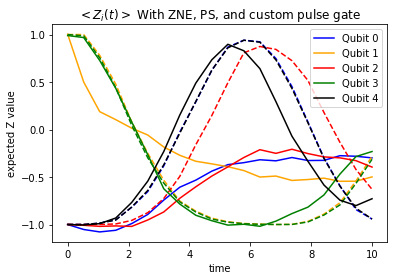

In [20]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
ax.plot(t, real_device_dict[0], label='Qubit 0', color = 'blue')
ax.plot(t, ideal_device_dict[0], linestyle = 'dashed', color = 'blue')
ax.plot(t, real_device_dict[1], label='Qubit 1', color = 'orange')
ax.plot(t, ideal_device_dict[1], linestyle = 'dashed', color = 'orange')
ax.plot(t, real_device_dict[2], label='Qubit 2', color = 'red')
ax.plot(t, ideal_device_dict[2], linestyle = 'dashed', color = 'red')
ax.plot(t, real_device_dict[3], label='Qubit 3', color = 'green')
ax.plot(t, ideal_device_dict[3], linestyle = 'dashed', color = 'green')
ax.plot(t, real_device_dict[4], label='Qubit 4', color = 'black')
ax.plot(t, ideal_device_dict[4], linestyle = 'dashed', color = 'black')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$<Z_i(t)>$ With ZNE, PS, and custom pulse gate")
ax.legend()

print('Generated using', backend)

In [21]:
def Trotter_circuit_5_site_DD(h,Omega,V,T,n,qubits_list):
    
    t1,t2=DD_T(h,Omega,V,T,n,qubits_list)
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            Trotter_circuit.y(q0)
            
            Trotter_circuit.delay(int(2*t1),q0,'dt')

            Trotter_circuit.z(q0)
            
            Trotter_circuit.y(q0)

            Trotter_circuit.z(q0)
            
            Trotter_circuit.delay(int(t1),q0,'dt')
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.y(q4)
            
            Trotter_circuit.delay(int(2*t2),q4,'dt')

            Trotter_circuit.z(q4)
            
            Trotter_circuit.y(q4)

            Trotter_circuit.z(q4)
            
            Trotter_circuit.delay(int(t2),q4,'dt')
            
            Trotter_circuit.barrier()
            
        # add the custom pulse gate into circuit
            
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

def Trotter_circuit_5_site_wo_m_one_step(h,Omega,V,T,n,qubits_list):
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
        
    Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
    X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
    h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
    ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
    # add the custom pulse gate into circuit
            
    Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt]) 
        
    Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])
        
    Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt])
        
    Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        

    Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
     
        
    return Trotter_circuit


def DD_T(h,Omega,V,T,n,qubits_list):
    
    Trotter_circuit=Trotter_circuit_5_site_wo_m_one_step(h,Omega,V,T,n,qubits_list)
    
    pulse_schedule = schedule(Trotter_circuit, backend)
    
    n0=1
    
    for i in range(len(pulse_schedule.instructions)):
        
        if pulse_schedule.instructions[i][1].channel.index==qubits_list[0]\
        and type(pulse_schedule.instructions[i][1].channels[0]) is not ControlChannel and n0==1:
            
            T_q1 = pulse_schedule.instructions[i][0]
            
            n0=0
            
        if pulse_schedule.instructions[i][1].channel.index==qubits_list[4]:
            
            T_q2 = pulse_schedule.instructions[i][0]
            
            
    T_q2=(pulse_schedule.duration-T_q2-480)/4
        
    T_q1=(T_q1-320)/4
    
    
    return T_q1, T_q2

In [22]:
Trotter_circuit_DD = Trotter_circuit_5_site_DD(h,Omega,V,T,n,qubits_list)

In [23]:
def folding_function_DD(t, scale_factor):
    output_circuit = Trotter_circuit_DD[t].copy()
    for x in range(1,scale_factor):
        output_circuit = output_circuit + Trotter_circuit_DD[t].inverse() + Trotter_circuit_DD[t]
        
    j=0
        
    for i in qubits_list:

        output_circuit.measure(i,j)

        j+=1
    
    return output_circuit

In [24]:
def TrotterExecutorDD(backend, shots, post_sel_func, n):
    scale_factors = [1.0, 2.0, 3.0]

    folded_circuits = []
    
    for t in range(len(Trotter_circuit_DD)):
        folded_circuits.append(folding_function_DD(t, 1))
        folded_circuits.append(folding_function_DD(t, 2))
        folded_circuits.append(folding_function_DD(t, 3))

    #for circuit in circuits:
    #    folded_circuits.append([zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    #folded_circuits = list(itertools.chain(*folded_circuits))

    #folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    results = job.result()
    mit_results = meas_filter.apply(results)

    zero_noise_values = {}
    
    # k: qubit
    for k in range(5):

        expectation_values = []
        
        for t in range(len(folded_circuits)):
            expectation_values.append(post_selected_expval(mit_results.get_counts(t),k))

        zero_noise_values[k] = []
        if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
        else: #device_sim
            fac = mitiq.zne.inference.LinearFactory(scale_factors)
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(fac.extrapolate(scale_factors, 
                expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

In [25]:
real_device_dict_with_DD = TrotterExecutorDD(backend, shots, post_selection, n)

Generated using ibmq_bogota


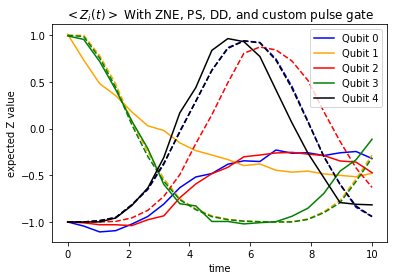

In [26]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
ax.plot(t, real_device_dict_with_DD[0], label='Qubit 0', color = 'blue')
ax.plot(t, ideal_device_dict[0], linestyle = 'dashed', color = 'blue')
ax.plot(t, real_device_dict_with_DD[1], label='Qubit 1', color = 'orange')
ax.plot(t, ideal_device_dict[1], linestyle = 'dashed', color = 'orange')
ax.plot(t, real_device_dict_with_DD[2], label='Qubit 2', color = 'red')
ax.plot(t, ideal_device_dict[2], linestyle = 'dashed', color = 'red')
ax.plot(t, real_device_dict_with_DD[3], label='Qubit 3', color = 'green')
ax.plot(t, ideal_device_dict[3], linestyle = 'dashed', color = 'green')
ax.plot(t, real_device_dict_with_DD[4], label='Qubit 4', color = 'black')
ax.plot(t, ideal_device_dict[4], linestyle = 'dashed', color = 'black')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$<Z_i(t)>$ With ZNE, PS, DD, and custom pulse gate")
ax.legend()

print('Generated using', backend)

All results generated from ibmq_bogota


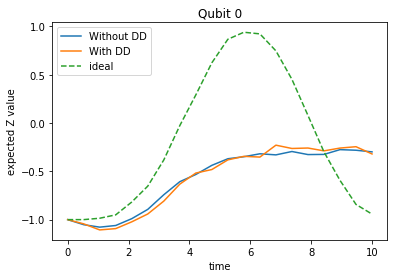

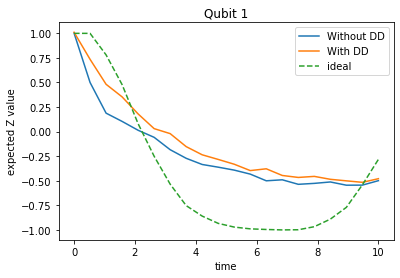

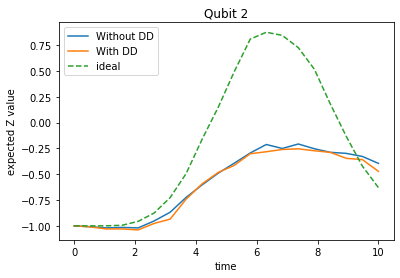

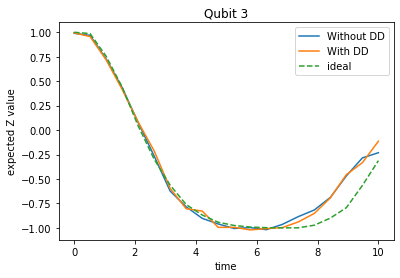

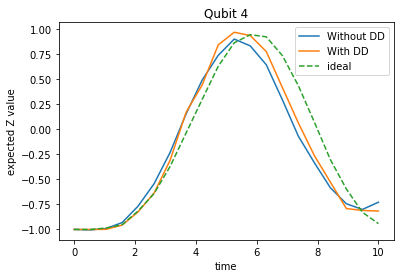

In [27]:
for x in range(backend_config.n_qubits):
    fig,ax = plt.subplots()
    ax.plot(t, real_device_dict[x], label = 'Without DD')
    ax.plot(t, real_device_dict_with_DD[x], label='With DD')
    ax.plot(t, ideal_device_dict[x], linestyle = 'dashed', label = 'ideal')
    ax.legend()
    
    ax.set_xlabel('time')
    ax.set_ylabel('expected Z value')
    ax.set_title("Qubit " + str(x))
    ax.legend()
print('All results generated from', backend)

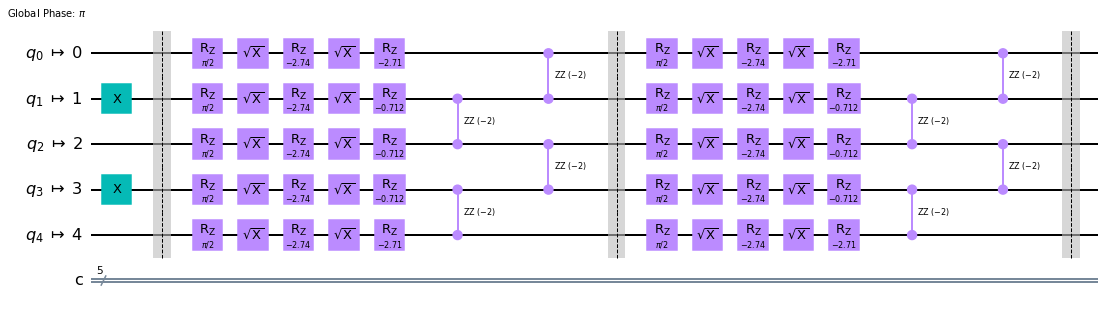

In [28]:
t = 2
Trotter_circuit[t].draw('mpl')

In [29]:
a = Trotter_circuit[t].qasm()
a

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nx q[1];\nx q[3];\nbarrier q[0],q[1],q[2],q[3],q[4];\nrz(pi/2) q[0];\nsx q[0];\nrz(-2.7415927) q[0];\nsx q[0];\nrz(-2.712389) q[0];\nrz(pi/2) q[1];\nsx q[1];\nrz(-2.7415927) q[1];\nsx q[1];\nrz(-0.71238898) q[1];\nrz(pi/2) q[2];\nsx q[2];\nrz(-2.7415927) q[2];\nsx q[2];\nrz(-0.71238898) q[2];\nrzz(-2) q[1],q[2];\nrzz(-2) q[0],q[1];\nrz(pi/2) q[3];\nsx q[3];\nrz(-2.7415927) q[3];\nsx q[3];\nrz(-0.71238898) q[3];\nrz(pi/2) q[4];\nsx q[4];\nrz(-2.7415927) q[4];\nsx q[4];\nrz(-2.712389) q[4];\nrzz(-2) q[3],q[4];\nrzz(-2) q[2],q[3];\nbarrier q[0],q[1],q[2],q[3],q[4];\nrz(pi/2) q[0];\nsx q[0];\nrz(-2.7415927) q[0];\nsx q[0];\nrz(-2.712389) q[0];\nrz(pi/2) q[1];\nsx q[1];\nrz(-2.7415927) q[1];\nsx q[1];\nrz(-0.71238898) q[1];\nrz(pi/2) q[2];\nsx q[2];\nrz(-2.7415927) q[2];\nsx q[2];\nrz(-0.71238898) q[2];\nrzz(-2) q[1],q[2];\nrzz(-2) q[0],q[1];\nrz(pi/2) q[3];\nsx q[3];\nrz(-2.7415927) q[3];\nsx q[3];\nrz(-0.71238898) q[3];\nrz(pi/

In [30]:
b = a.split(';')

In [31]:
c = ';'.join(b)
c

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nx q[1];\nx q[3];\nbarrier q[0],q[1],q[2],q[3],q[4];\nrz(pi/2) q[0];\nsx q[0];\nrz(-2.7415927) q[0];\nsx q[0];\nrz(-2.712389) q[0];\nrz(pi/2) q[1];\nsx q[1];\nrz(-2.7415927) q[1];\nsx q[1];\nrz(-0.71238898) q[1];\nrz(pi/2) q[2];\nsx q[2];\nrz(-2.7415927) q[2];\nsx q[2];\nrz(-0.71238898) q[2];\nrzz(-2) q[1],q[2];\nrzz(-2) q[0],q[1];\nrz(pi/2) q[3];\nsx q[3];\nrz(-2.7415927) q[3];\nsx q[3];\nrz(-0.71238898) q[3];\nrz(pi/2) q[4];\nsx q[4];\nrz(-2.7415927) q[4];\nsx q[4];\nrz(-2.712389) q[4];\nrzz(-2) q[3],q[4];\nrzz(-2) q[2],q[3];\nbarrier q[0],q[1],q[2],q[3],q[4];\nrz(pi/2) q[0];\nsx q[0];\nrz(-2.7415927) q[0];\nsx q[0];\nrz(-2.712389) q[0];\nrz(pi/2) q[1];\nsx q[1];\nrz(-2.7415927) q[1];\nsx q[1];\nrz(-0.71238898) q[1];\nrz(pi/2) q[2];\nsx q[2];\nrz(-2.7415927) q[2];\nsx q[2];\nrz(-0.71238898) q[2];\nrzz(-2) q[1],q[2];\nrzz(-2) q[0],q[1];\nrz(pi/2) q[3];\nsx q[3];\nrz(-2.7415927) q[3];\nsx q[3];\nrz(-0.71238898) q[3];\nrz(pi/

True


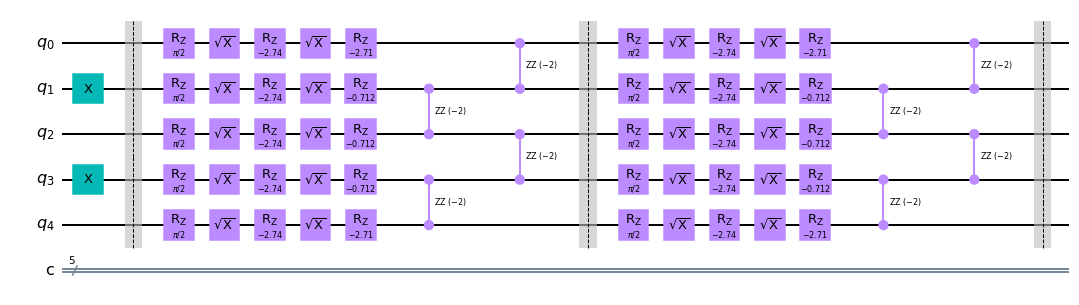

In [32]:
print(a == c)

QuantumCircuit.from_qasm_str(c).draw('mpl')

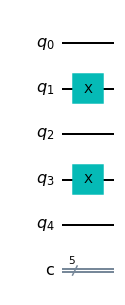

In [33]:
my_qasm_str = 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nx q[1];\nx q[3];'

test_circ = QuantumCircuit.from_qasm_str(my_qasm_str)
test_circ.draw('mpl')

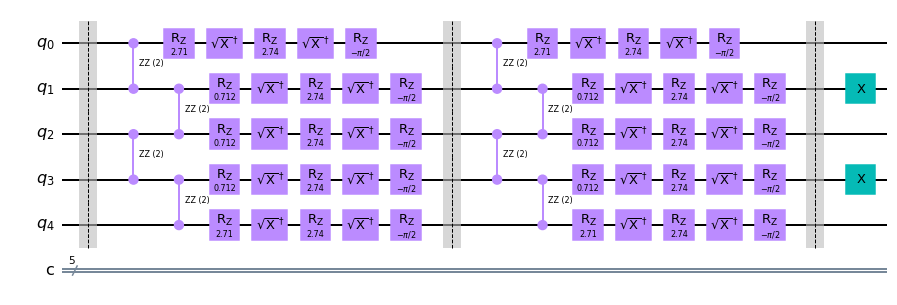

In [34]:
QuantumCircuit.from_qasm_str(c).inverse().draw('mpl')

In [35]:
QuantumCircuit.from_qasm_str(c).inverse().qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncreg c[5];\nbarrier q[0],q[1],q[2],q[3],q[4];\nrzz(2) q[2],q[3];\nrzz(2) q[3],q[4];\nrz(2.712389) q[4];\nsxdg q[4];\nrz(2.7415927) q[4];\nsxdg q[4];\nrz(-pi/2) q[4];\nrz(0.71238898) q[3];\nsxdg q[3];\nrz(2.7415927) q[3];\nsxdg q[3];\nrz(-pi/2) q[3];\nrzz(2) q[0],q[1];\nrzz(2) q[1],q[2];\nrz(0.71238898) q[2];\nsxdg q[2];\nrz(2.7415927) q[2];\nsxdg q[2];\nrz(-pi/2) q[2];\nrz(0.71238898) q[1];\nsxdg q[1];\nrz(2.7415927) q[1];\nsxdg q[1];\nrz(-pi/2) q[1];\nrz(2.712389) q[0];\nsxdg q[0];\nrz(2.7415927) q[0];\nsxdg q[0];\nrz(-pi/2) q[0];\nbarrier q[0],q[1],q[2],q[3],q[4];\nrzz(2) q[2],q[3];\nrzz(2) q[3],q[4];\nrz(2.712389) q[4];\nsxdg q[4];\nrz(2.7415927) q[4];\nsxdg q[4];\nrz(-pi/2) q[4];\nrz(0.71238898) q[3];\nsxdg q[3];\nrz(2.7415927) q[3];\nsxdg q[3];\nrz(-pi/2) q[3];\nrzz(2) q[0],q[1];\nrzz(2) q[1],q[2];\nrz(0.71238898) q[2];\nsxdg q[2];\nrz(2.7415927) q[2];\nsxdg q[2];\nrz(-pi/2) q[2];\nrz(0.71238898) q[1];\nsxdg q[1];\nrz(2.7415927) q

In [36]:
len(b)

68

In [37]:
from numpy.random import default_rng
seed = 1234

rng = default_rng(seed)

probability = .5

output_list = []

for x in b:
    sample = rng.random()
    if sample < probability and x[len(x)-4::] in ['q[0]','q[1]','q[2]','q[3]','q[4]'] and '\nbarrier' not in x:
        output_list.append(x)
    else:
        output_list.append(0)
    
print(output_list)
print(len(output_list))

[0, 0, 0, 0, '\nx q[1]', '\nx q[3]', 0, '\nrz(pi/2) q[0]', 0, '\nrz(-2.7415927) q[0]', '\nsx q[0]', 0, 0, 0, 0, 0, 0, '\nrz(pi/2) q[2]', '\nsx q[2]', 0, '\nsx q[2]', 0, 0, 0, '\nrz(pi/2) q[3]', 0, '\nrz(-2.7415927) q[3]', 0, '\nrz(-0.71238898) q[3]', '\nrz(pi/2) q[4]', 0, '\nrz(-2.7415927) q[4]', 0, 0, '\nrzz(-2) q[3],q[4]', 0, 0, 0, '\nsx q[0]', '\nrz(-2.7415927) q[0]', 0, '\nrz(-2.712389) q[0]', 0, 0, 0, '\nsx q[1]', '\nrz(-0.71238898) q[1]', '\nrz(pi/2) q[2]', '\nsx q[2]', '\nrz(-2.7415927) q[2]', 0, 0, '\nrzz(-2) q[1],q[2]', '\nrzz(-2) q[0],q[1]', 0, 0, '\nrz(-2.7415927) q[3]', '\nsx q[3]', 0, 0, '\nsx q[4]', 0, 0, 0, '\nrzz(-2) q[3],q[4]', 0, 0, 0]
68


In [38]:
def get_argument(any_str):
    argument = ''
    switch = False
    for x in any_str:
        if x == '(':
            switch = True
            continue
        if x == ')':
            switch = False
        if switch:
            argument += x
    return argument

def get_inverse(gate_str):
    split_gate_str = gate_str.split(' ')
    gate_list = ['\nrzz( )', '\nid', '\nmeasure', '\nrz( )', '\nsx', '\nu1', '\nu2', '\nu3', '\nx']
    inverse_map = {'\nrzz':'\nrzz', '\nid':'\nid', '\nrz':'\nrz', '\nsx':'\nsxdg', '\nu1':'\nu1dg', 
                   '\nu2':'\nu2dg', '\nu3':'\nu3dg', '\nx':'\nx'}
    
    if split_gate_str[0][:5] == '\nrzz(':
        argument = get_argument(split_gate_str[0])
        if argument[0] == '-':
            argument = argument[1:]
        else:
            argument = '-' + argument
        return '\nrzz(' + argument + ')' + ' ' + split_gate_str[1] + ';'
    if split_gate_str[0][:4] == '\nrz(':
        argument = get_argument(split_gate_str[0])
        if argument[0] == '-':
            argument = argument[1:]
        else:
            argument = '-' + argument
        return '\nrz(' + argument + ')' + ' ' + split_gate_str[1] + ';'
    else:
        try:
            return inverse_map[split_gate_str[0]] + ' ' + split_gate_str[1] + ';'
        except KeyError:
            pass

In [39]:
any_str = '\nrz(-pi/2) q[3]'

get_argument(any_str)

'-pi/2'

In [40]:
split_gate_str = '\nrzz(-2) q[3]'.split(' ')

# split_gate_str[0][:5] == '\nrzz('

# split_gate_str[0][:4] == '\nrz('

get_inverse('\nsx q[3]')

'\nsxdg q[3];'

In [43]:
def folder_func(rand_seed, prob, circuit):
    qasm_str = circuit.qasm()
    qasm_list = qasm_str.split(';')

    rng = default_rng(rand_seed)
    probability = prob

    for i,x in enumerate(qasm_list):
        sample = rng.random()
        if sample < probability and x[len(x)-4::] in ['q[0]','q[1]','q[2]','q[3]','q[4]'] and '\nbarrier' not in x:
            qasm_list.insert(i, x + ';' + get_inverse(x))

    raw_folded_qasm_str = ';'.join(qasm_list)

    raw_folded_qasm_list = raw_folded_qasm_str.split(' ')

    for i,item in enumerate(raw_folded_qasm_list):
        if ';;' in item:
            raw_folded_qasm_list[i] = item.replace(';;', ';')

    fixed_folded_qasm_str = ' '.join(raw_folded_qasm_list)

    output_circ = QuantumCircuit.from_qasm_str(fixed_folded_qasm_str)

#         j=0

#         for i in qubits_list:

#             output_circ.measure(i,j)

#             j+=1
    
    return output_circ
    

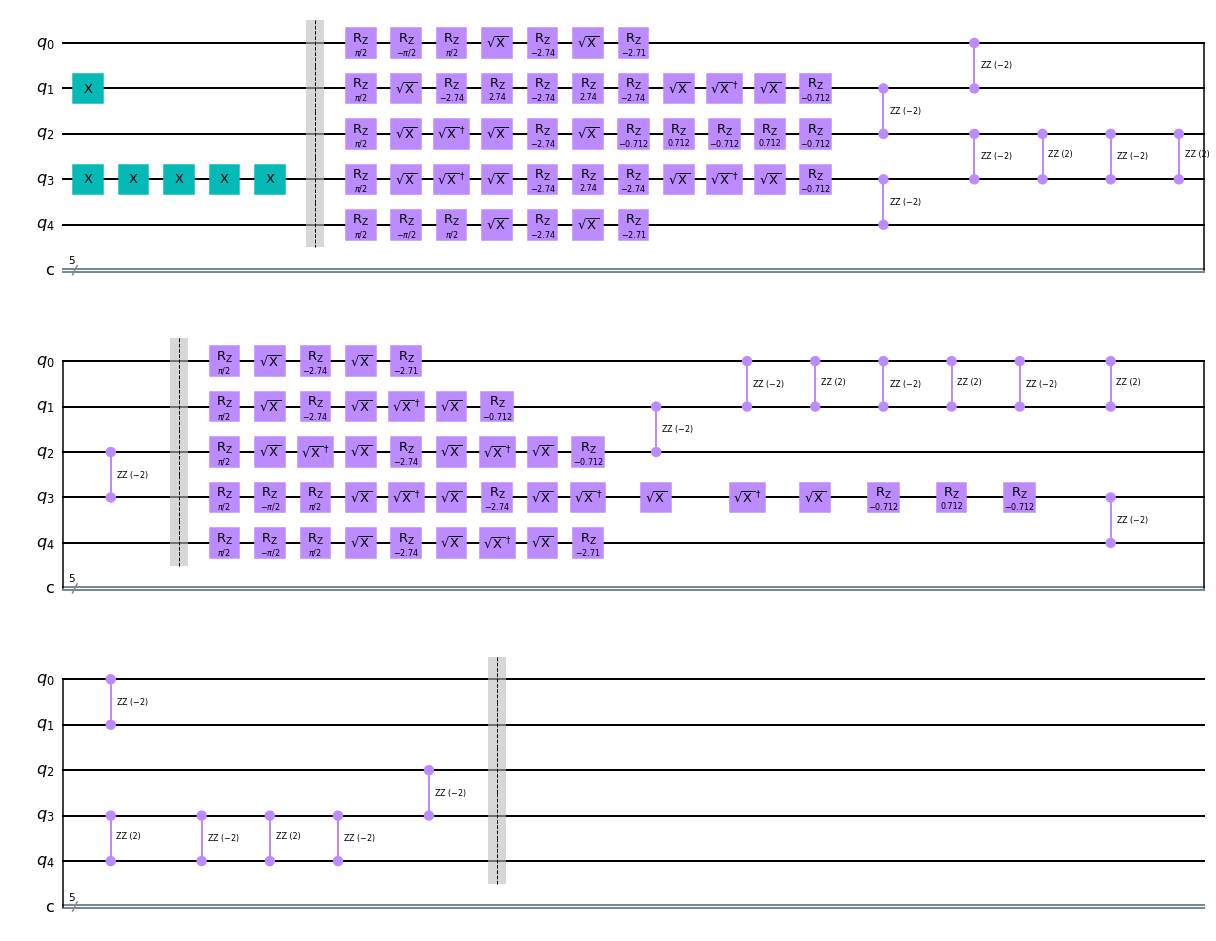

In [46]:
folder_func(1234, .3, Trotter_circuit[2]).draw('mpl')

In [45]:
scale1 = folder_func(1234, .3, Trotter_circuit[2])
scale2 = folder_func(1234, .3, scale1)

TypeError: can only concatenate str (not "NoneType") to str

In [ ]:
chosen_seed = 1234

folded_circuits = []

for time in range(len(Trotter_circuit)):
    for scale_factor in range(1,4):
        folded_circuit_scale1 = folder_func(chosen_seed, .3, Trotter_circuit[time])
        folded_circuit_scale2 = folder_func(chosen_seed, .3, folded_circuit_scale1)
        folded_circuit_scale3 = folder_func(chosen_seed, .3, folded_circuit_scale2)
        
        folded_circuits.append(folded_circuit_scale1)
        folded_circuits.append(folded_circuit_scale2)
        folded_circuits.append(folded_circuit_scale3)

In [ ]:
# def TwirledCNOT(circ, qb0, qb1):
#     def apply_pauli(circ, num, qb):
#         if (num == 0):
#             circ.i(qb)
#         elif (num == 1):
#             circ.x(qb)
#         elif (num == 2):
#             circ.y(qb)
#         else:
#             circ.z(qb)
#         return circ

#     paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
#     paulis.remove((0,0))
#     paulis_map = [(0, 1), (3, 2), (3, 3), (1, 1), (1, 0), (2, 3), (2, 2), (2, 1), 
#                   (2, 0), (1, 3), (1, 2), (3, 0), (3, 1), (0, 2), (0, 3)]
#     num = random.randrange(len(paulis))

#     apply_pauli(circ, paulis[num][0], qb0)
#     apply_pauli(circ, paulis[num][1], qb1)
#     circ.cnot(qb0, qb1)
#     apply_pauli(circ, paulis_map[num][0], qb0)
#     apply_pauli(circ, paulis_map[num][1], qb1)
#     return circ

def TwirledRZZ(circ, qb0, qb1):
    def apply_pauli(circ, num, qb):
        if (num == 0):
            circ.i(qb)
        elif (num == 1):
            circ.x(qb)
        elif (num == 2):
            circ.y(qb)
        else:
            circ.z(qb)
        return circ

    paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
    paulis.remove((0,0))
    paulis_map = [(0, 1), (3, 2), (3, 3), (1, 1), (1, 0), (2, 3), (2, 2), (2, 1), 
                  (2, 0), (1, 3), (1, 2), (3, 0), (3, 1), (0, 2), (0, 3)]
    num = random.randrange(len(paulis))

    apply_pauli(circ, paulis[num][0], qb0)
    apply_pauli(circ, paulis[num][1], qb1)
    circ.rzz(qb0, qb1)
    apply_pauli(circ, paulis_map[num][0], qb0)
    apply_pauli(circ, paulis_map[num][1], qb1)
    return circ


In [ ]:
qc = QuantumCircuit(2,2)

qc.rzz(-2,0,1)

qc.draw('mpl')

In [ ]:
test_list = [1,2,3,4,5]
test_list.insert(2,2.5)

print(test_list)

In [ ]:
test_str = ';hello there;;'

test_str.replace('l','',1)

print(test_str)

In [ ]:
for i,character in enumerate(test_str):
    if character == ';' and test_str[i-1] == ';':
        test_str = test_str.replace(test_str[i],'')
        
print(test_str)